In [80]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [81]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

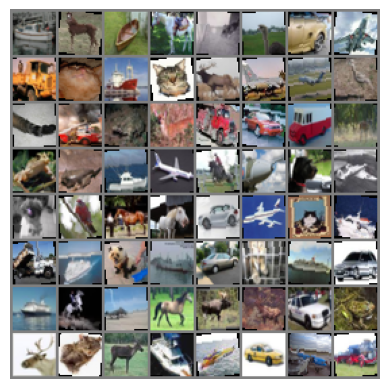

Labels: ship horse ship horse


In [82]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.show()
for i, (images, labels) in enumerate(trainloader, 0):
    imshow(torchvision.utils.make_grid(images))
    print("Labels:", ' '.join(f'{classes[labels[j]]}' for j in range(4)))
    break

+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [83]:
import torch
import torch.nn as nn

def getModel(n_features):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_features, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(4096, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(256, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, 10)  # Lớp đầu ra cho bài toán phân loại 10 lớp
    )
    return model


+ Khởi tạo hàm loss function và phương thức optimizer

In [84]:
n_features = 3 * 32 * 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.0005  # Learning rate cho Adam

# Khởi tạo mô hình, optimizer và loss function
model = getModel(n_features).to(device)
optim = optim.Adam(model.parameters(), lr=lr)  # Sử dụng Adam
loss_fn = nn.CrossEntropyLoss()

scheduler = StepLR(optim, step_size=10, gamma=0.1)

+ Xây dựng hàm đánh giá model

In [85]:
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy


+ Bắt đầu training và đánh giá model.

In [ ]:
n_epochs = 100
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        inputs, labels = inputs.to(device), labels.to(device)



        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()
    
    scheduler.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 2.4376, Accuracy: 10.06%, Test Loss: 2.3074, Test Accuracy: 10.01%
Epoch [2/100], Loss: 2.3077, Accuracy: 10.04%, Test Loss: 2.3075, Test Accuracy: 10.05%


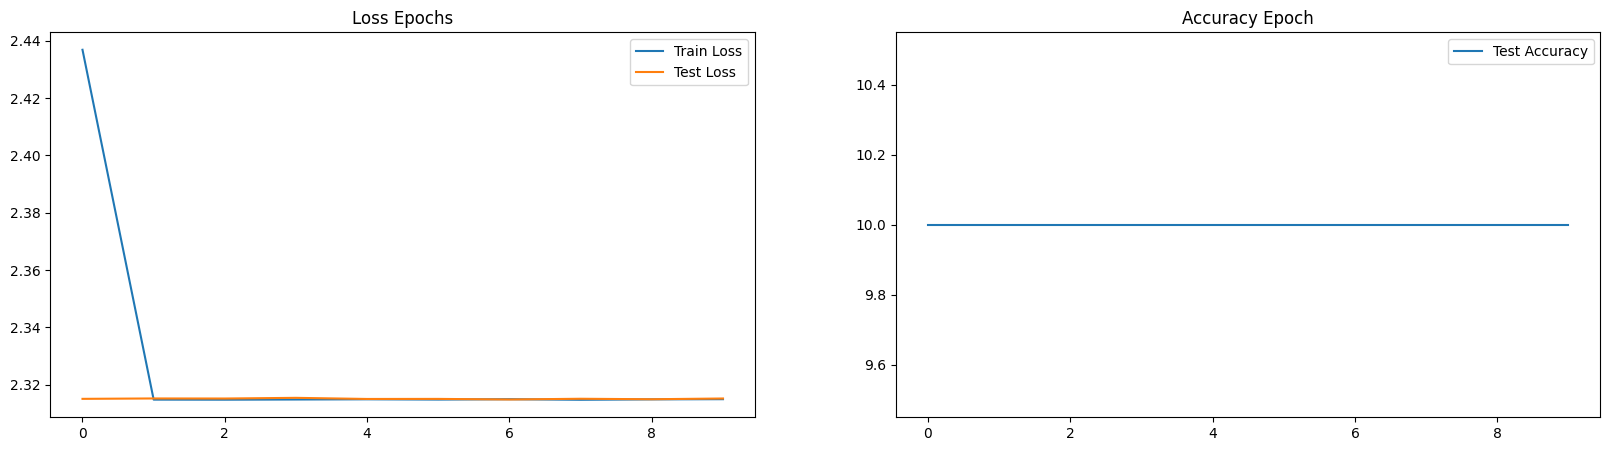

In [49]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()

+ Dưới đây là bài tập về code from scratch

In [50]:
def zScoreScaling(tensor):

SyntaxError: incomplete input (278598926.py, line 1)

In [76]:
def minMaxScaling(tensor):

In [61]:
class Linear:
    

In [77]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


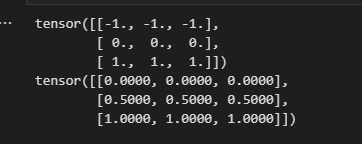

In [ ]:
tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")